Restaurants receive thousands of customer reviews, but star ratings alone fail to explain why ratings increase or decline. Reviews often contain rich information about food quality, service, pricing, ambience, and operational factors, yet this information remains unstructured and difficult to analyze at scale. This limits restaurants’ ability to identify the drivers of customer satisfaction and dissatisfaction

Notebook 3: Insight Analysis

This notebook performs exploratory and diagnostic analysis on a previously constructed review-level dataset (aspect_df) to explain why restaurant ratings vary.

By analyzing sentiment distributions across review topics (aspects) and linking them to restaurant operational attributes, this notebook identifies the key drivers of positive and negative customer sentiment. The goal is to translate unstructured review text into actionable insights that help explain changes in star ratings beyond the ratings themselves.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Prepared Analytical Dataset

In [2]:
import pandas as pd
import pickle

PATH = "/content/drive/MyDrive/restaurant_sentiment_model/aspect_df.pkl"

#load
aspect_df = pd.read_pickle(PATH)


In [3]:
aspect_df.head()

,business_id,review,topic,sentiment,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,YtSqYv1Q_pOltsVPSx54SA,Tremendous service (Big shout out to Douglas) ...,-1,2,Unknown,Unknown,'full_bar',"{'romantic': False, 'intimate': False, 'classy...",Unknown,Unknown,...,Unknown,True,True,3,True,Unknown,True,Unknown,True,'free'
1,aY_n9RSaD2Yw09jSFFePew,We visited once and were very disappointed in ...,3,0,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,Unknown,True,True,2,False,False,True,Unknown,True,u'free'
2,18eWJFJbXyR9j_5xfcRLYA,This is the first time I tried this place and ...,6,2,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,Unknown,True,True,2,True,True,True,Unknown,True,u'no'
3,jOOOrH5n2ijnsZKxzPSAiw,This is one of the busiest Chick fil A's I've ...,-1,2,Unknown,Unknown,u'none',"{'romantic': False, 'intimate': False, 'touris...",Unknown,Unknown,...,Unknown,True,True,1,False,False,True,Unknown,Unknown,u'free'
4,1QVB0_-piu0GXes87BXeGw,Love this place...best hot dogs and chili dogs...,-1,2,Unknown,Unknown,u'none',"{'touristy': False, 'hipster': False, 'romanti...",Unknown,Unknown,...,Unknown,True,True,1,False,False,True,Unknown,True,u'free'


In [4]:
aspect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   business_id                 10000 non-null  object
 1   review                      10000 non-null  object
 2   topic                       10000 non-null  int64 
 3   sentiment                   10000 non-null  int64 
 4   AcceptsInsurance            10000 non-null  object
 5   AgesAllowed                 10000 non-null  object
 6   Alcohol                     10000 non-null  object
 7   Ambience                    10000 non-null  object
 8   BYOB                        10000 non-null  object
 9   BYOBCorkage                 10000 non-null  object
 10  BestNights                  10000 non-null  object
 11  BikeParking                 10000 non-null  object
 12  BusinessAcceptsBitcoin      10000 non-null  object
 13  BusinessAcceptsCreditCards  10000 non-null  obj

In [5]:
pip install -U bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 15.9 MB/s eta 0:00:00


In [6]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
MODEL_PATH = "/content/drive/MyDrive/restaurant_sentiment_model/aspect"
topic_model = BERTopic.load(
    MODEL_PATH,
    embedding_model=embedding_model
)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic and Sentiment Label Mapping

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

#Map sentiment labels
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
aspect_df['sentiment_label'] = aspect_df['sentiment'].map(sentiment_mapping)

#Map topic IDs to descriptive labels
topic_info = topic_model.get_topic_info()

topic_mapping = {}
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        topic_mapping[topic_id] = "Other / Outliers"
    else:
        words = [word for word, _ in topic_model.get_topic(topic_id)[:3]]  # top 3 words
        topic_mapping[topic_id] = " ".join(words)

aspect_df['topic_label'] = aspect_df['topic'].map(topic_mapping)

In [8]:
aspect_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   business_id                 10000 non-null  object
 1   review                      10000 non-null  object
 2   topic                       10000 non-null  int64 
 3   sentiment                   10000 non-null  int64 
 4   AcceptsInsurance            10000 non-null  object
 5   AgesAllowed                 10000 non-null  object
 6   Alcohol                     10000 non-null  object
 7   Ambience                    10000 non-null  object
 8   BYOB                        10000 non-null  object
 9   BYOBCorkage                 10000 non-null  object
 10  BestNights                  10000 non-null  object
 11  BikeParking                 10000 non-null  object
 12  BusinessAcceptsBitcoin      10000 non-null  object
 13  BusinessAcceptsCreditCards  10000 non-null  obj

In [9]:
aspect_df.head()

,business_id,review,topic,sentiment,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,...,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,sentiment_label,topic_label
0,YtSqYv1Q_pOltsVPSx54SA,Tremendous service (Big shout out to Douglas) ...,-1,2,Unknown,Unknown,'full_bar',"{'romantic': False, 'intimate': False, 'classy...",Unknown,Unknown,...,True,3,True,Unknown,True,Unknown,True,'free',Positive,Other / Outliers
1,aY_n9RSaD2Yw09jSFFePew,We visited once and were very disappointed in ...,3,0,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,False,False,True,Unknown,True,u'free',Negative,pizza crust it
2,18eWJFJbXyR9j_5xfcRLYA,This is the first time I tried this place and ...,6,2,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,True,True,True,Unknown,True,u'no',Positive,thai pad curry
3,jOOOrH5n2ijnsZKxzPSAiw,This is one of the busiest Chick fil A's I've ...,-1,2,Unknown,Unknown,u'none',"{'romantic': False, 'intimate': False, 'touris...",Unknown,Unknown,...,True,1,False,False,True,Unknown,Unknown,u'free',Positive,Other / Outliers
4,1QVB0_-piu0GXes87BXeGw,Love this place...best hot dogs and chili dogs...,-1,2,Unknown,Unknown,u'none',"{'touristy': False, 'hipster': False, 'romanti...",Unknown,Unknown,...,True,1,False,False,True,Unknown,True,u'free',Positive,Other / Outliers


In [10]:
filtered_df = aspect_df[aspect_df["topic"] != -1]


In [11]:
filtered_df.head()

,business_id,review,topic,sentiment,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,...,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,sentiment_label,topic_label
1,aY_n9RSaD2Yw09jSFFePew,We visited once and were very disappointed in ...,3,0,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,False,False,True,Unknown,True,u'free',Negative,pizza crust it
2,18eWJFJbXyR9j_5xfcRLYA,This is the first time I tried this place and ...,6,2,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,True,True,True,Unknown,True,u'no',Positive,thai pad curry
7,9OG5YkX1g2GReZM0AskizA,Great bar Happy Hour 4-7 every day. Wine & Dra...,1,2,Unknown,Unknown,'full_bar',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,True,True,True,Unknown,Unknown,u'free',Positive,beer bar beers
8,LnQRfj3pPz0369stRnwUWw,Very good sushi. The peanut avocado roll is a ...,4,2,Unknown,Unknown,u'beer_and_wine',"{u'divey': False, u'hipster': False, u'casual'...",Unknown,Unknown,...,True,2,True,True,True,Unknown,Unknown,u'free',Positive,sushi roll rolls
12,Mha77MN_BYGB-w7DONZ5YA,Our group of 6 decided to try something differ...,17,2,Unknown,Unknown,u'none',"{'romantic': False, 'intimate': False, 'touris...",Unknown,Unknown,...,True,1,False,Unknown,True,Unknown,Unknown,'no',Positive,vegan vegetarian options


In [12]:
import pickle

PATH = "/content/drive/MyDrive/restaurant_sentiment_model/filtered_df.pkl"

#Save
filtered_df.to_pickle(PATH)

#Later, load
filtered_df = pd.read_pickle(PATH)


Most Discussed Restaurant Aspects

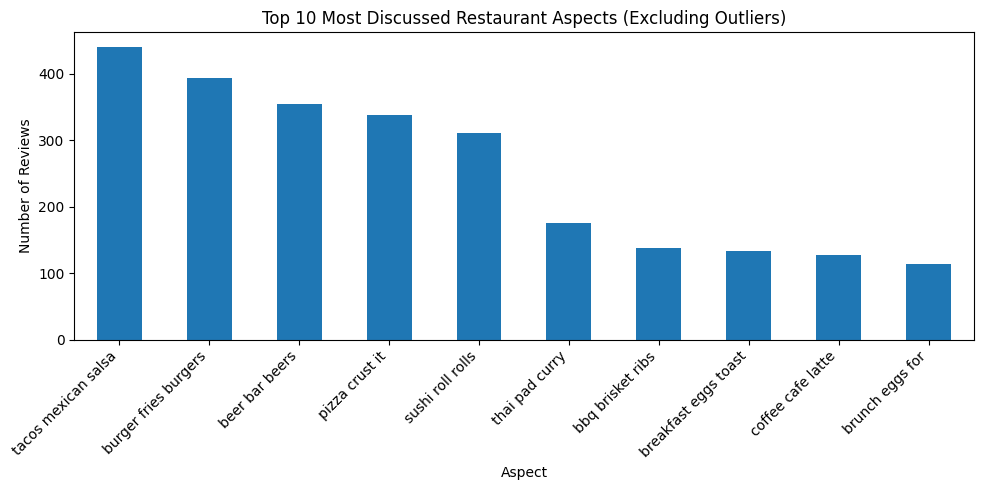

In [13]:
import matplotlib.pyplot as plt

topic_counts = (
    filtered_df["topic_label"]
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
topic_counts.plot(kind="bar")
plt.title("Top 10 Most Discussed Restaurant Aspects (Excluding Outliers)")
plt.xlabel("Aspect")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Sentiment Distribution by Restaurant Aspect

<Figure size 1000x500 with 0 Axes>

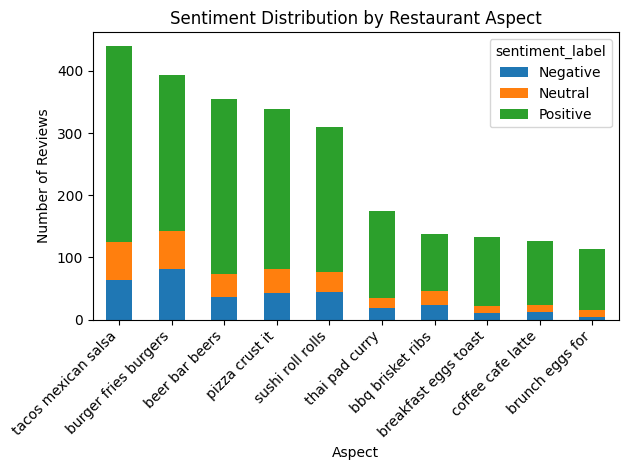

In [14]:
sentiment_topic = (
    aspect_df
    .groupby(["topic_label", "sentiment_label"])
    .size()
    .unstack(fill_value=0)
    .loc[topic_counts.index]
)

plt.figure(figsize=(10,5))
sentiment_topic.plot(kind="bar", stacked=True)
plt.title("Sentiment Distribution by Restaurant Aspect")
plt.xlabel("Aspect")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Net Sentiment of Restaurent topics

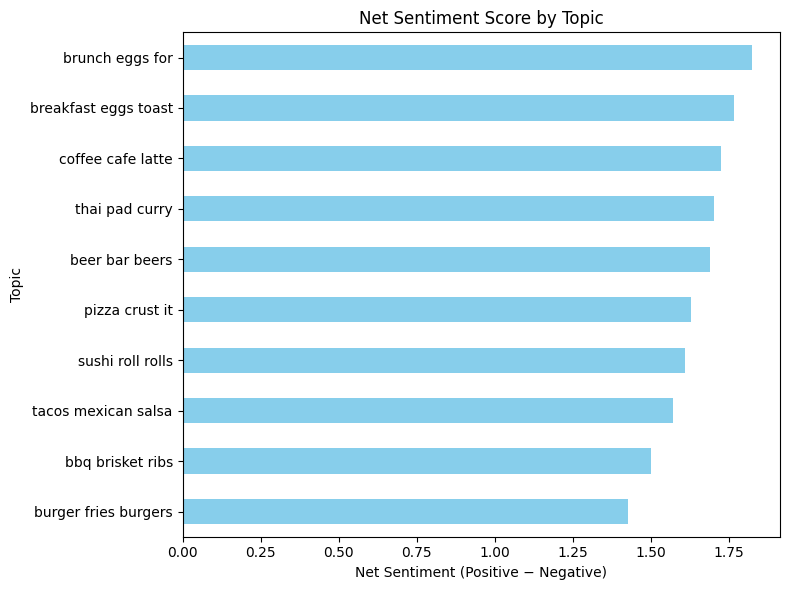

In [30]:
import matplotlib.pyplot as plt

#Get top 10 topics
top_topics = filtered_df['topic_label'].value_counts().head(10).index

#Filter dataframe to only include top topics
filtered_top_df = filtered_df[filtered_df['topic_label'].isin(top_topics)]

#Calculate mean net sentiment by topic
net_sentiment = (
    filtered_top_df
    .groupby("topic_label")["sentiment"]
    .mean()
    .sort_values()
)

#Plot horizontal bar chart
plt.figure(figsize=(8,6))
net_sentiment.plot(kind="barh", color="skyblue")
plt.title("Net Sentiment Score by Topic")
plt.xlabel("Net Sentiment (Positive − Negative)")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


Deep-Dive Analysis: Aspect-Specific Drivers

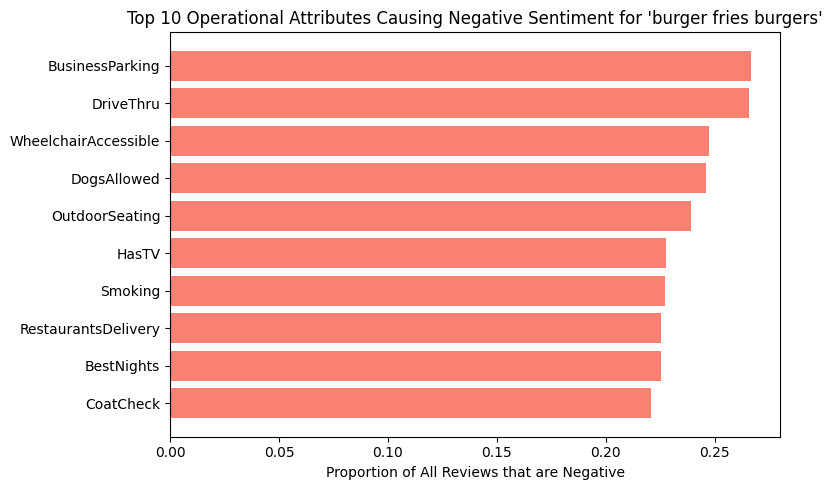

In [15]:
import matplotlib.pyplot as plt

# Define topic
topic = "burger fries burgers"

# Filter for topic
topic_df = filtered_df[filtered_df["topic_label"] == topic]

# Automatically detect operational attributes
exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
operational_attributes = [col for col in topic_df.columns if col not in exclude_cols]

# Compute proportion of negative reviews for each attribute relative to all reviews
neg_attr_scores = {}

for attr in operational_attributes:
    if topic_df[attr].dtype == 'object':
        # Get all reviews for this attribute value
        counts = topic_df.groupby(attr)["sentiment_label"].value_counts(normalize=True)
        # Take the proportion of negative sentiment for the most common attribute value
        most_common_value = topic_df[attr].mode()[0]
        neg_score = counts.get((most_common_value, "Negative"), 0)
        neg_attr_scores[attr] = neg_score

# Sort descending and take top 5
top5_neg_attrs = sorted(neg_attr_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
attrs, scores = zip(*top5_neg_attrs)

plt.figure(figsize=(8,5))
plt.barh(attrs, scores, color='salmon')
plt.xlabel("Proportion of All Reviews that are Negative")
plt.title(f"Top 10 Operational Attributes Causing Negative Sentiment for '{topic}'")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


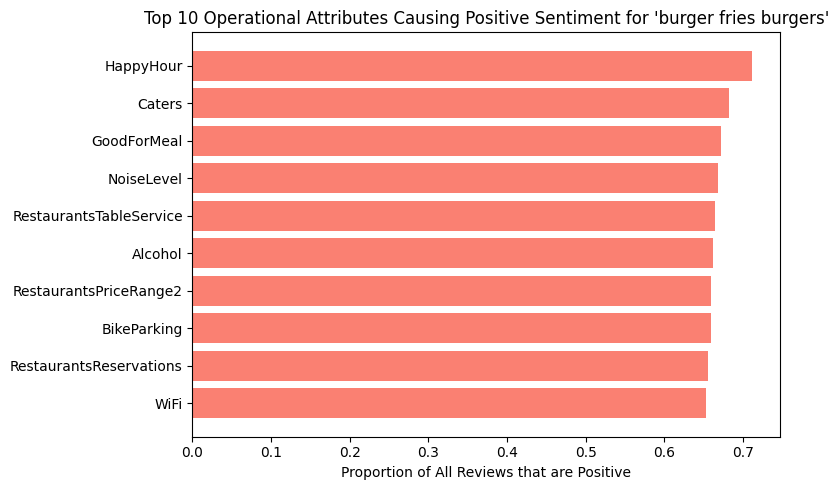

In [16]:
import matplotlib.pyplot as plt

# Define topic
topic = "burger fries burgers"

# Filter for topic
topic_df = filtered_df[filtered_df["topic_label"] == topic]

# Automatically detect operational attributes
exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
operational_attributes = [col for col in topic_df.columns if col not in exclude_cols]

# Compute proportion of positive reviews for each attribute relative to all reviews
pos_attr_scores = {}

for attr in operational_attributes:
    if topic_df[attr].dtype == 'object':
        # Get all reviews for this attribute value
        counts = topic_df.groupby(attr)["sentiment_label"].value_counts(normalize=True)
        # Take the proportion of positive sentiment for the most common attribute value
        most_common_value = topic_df[attr].mode()[0]
        pos_score = counts.get((most_common_value, "Positive"), 0)
        pos_attr_scores[attr] = pos_score

# Sort descending and take top 5
top5_pos_attrs = sorted(pos_attr_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot
attrs, scores = zip(*top5_pos_attrs)

plt.figure(figsize=(8,5))
plt.barh(attrs, scores, color='salmon')
plt.xlabel("Proportion of All Reviews that are Positive")
plt.title(f"Top 10 Operational Attributes Causing Positive Sentiment for '{topic}'")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


In [17]:
import matplotlib.pyplot as plt

def plot_top_negative_attributes(filtered_df, topic):
    # Define topic
    topic = topic

    # Filter for topic
    topic_df = filtered_df[filtered_df["topic_label"] == topic]

    # Automatically detect operational attributes
    exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
    operational_attributes = [col for col in topic_df.columns if col not in exclude_cols]

    # Compute proportion of negative reviews for each attribute relative to all reviews
    neg_attr_scores = {}

    for attr in operational_attributes:
        if topic_df[attr].dtype == 'object':
            # Get all reviews for this attribute value
            counts = topic_df.groupby(attr)["sentiment_label"].value_counts(normalize=True)
            # Take the proportion of negative sentiment for the most common attribute value
            most_common_value = topic_df[attr].mode()[0]
            neg_score = counts.get((most_common_value, "Negative"), 0)
            neg_attr_scores[attr] = neg_score

    # Sort descending and take top 5
    top5_neg_attrs = sorted(neg_attr_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    # Plot
    attrs, scores = zip(*top5_neg_attrs)

    plt.figure(figsize=(8,5))
    plt.barh(attrs, scores, color='salmon')
    plt.xlabel("Proportion of All Reviews that are Negative")
    plt.title(f"Top 10 Operational Attributes Causing Negative Sentiment for '{topic}'")
    plt.gca().invert_yaxis()  # highest at top
    plt.tight_layout()
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_top_positive_attributes(filtered_df, topic):
    # Define topic
    topic = topic

    # Filter for topic
    topic_df = filtered_df[filtered_df["topic_label"] == topic]

    # Automatically detect operational attributes
    exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
    operational_attributes = [col for col in topic_df.columns if col not in exclude_cols]

    # Compute proportion of positive reviews for each attribute relative to all reviews
    pos_attr_scores = {}

    for attr in operational_attributes:
        if topic_df[attr].dtype == 'object':
            # Get all reviews for this attribute value
            counts = topic_df.groupby(attr)["sentiment_label"].value_counts(normalize=True)
            # Take the proportion of positive sentiment for the most common attribute value
            most_common_value = topic_df[attr].mode()[0]
            pos_score = counts.get((most_common_value, "Positive"), 0)
            pos_attr_scores[attr] = pos_score

    # Sort descending and take top 5
    top5_pos_attrs = sorted(pos_attr_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    # Plot
    attrs, scores = zip(*top5_pos_attrs)

    plt.figure(figsize=(8,5))
    plt.barh(attrs, scores, color='salmon')
    plt.xlabel("Proportion of All Reviews that are Positive")
    plt.title(f"Top 10 Operational Attributes Causing Positive Sentiment for '{topic}'")
    plt.gca().invert_yaxis()  # highest at top
    plt.tight_layout()
    plt.show()


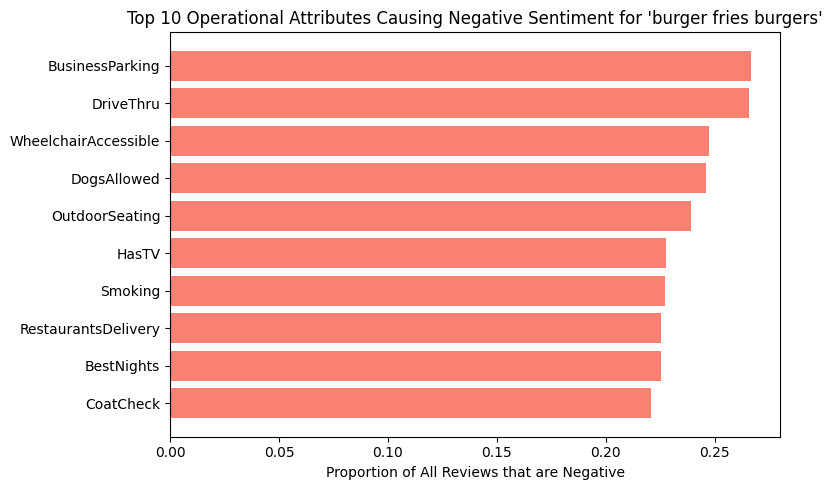

In [19]:
plot_top_negative_attributes(
    filtered_df,
    topic="burger fries burgers"
)


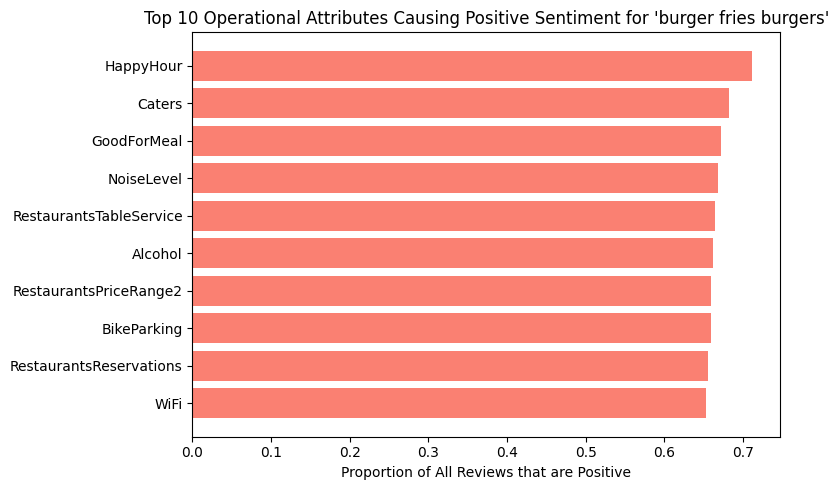

In [20]:
plot_top_positive_attributes(
    filtered_df,
    topic="burger fries burgers"
)


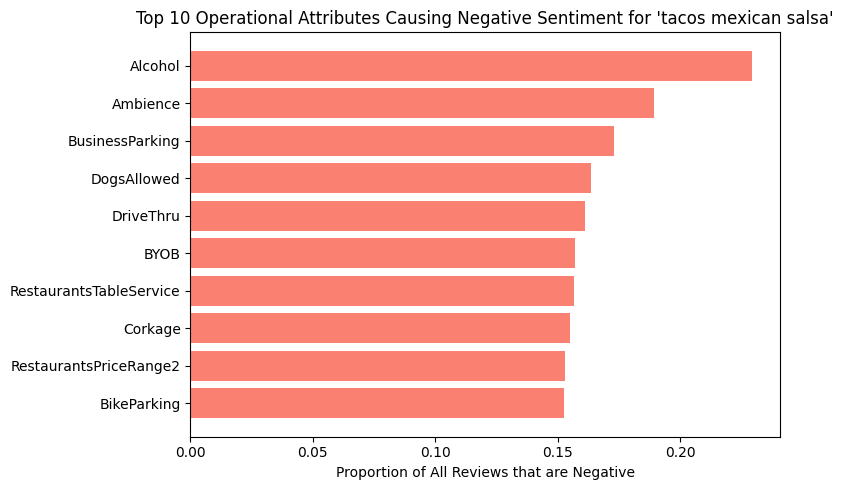

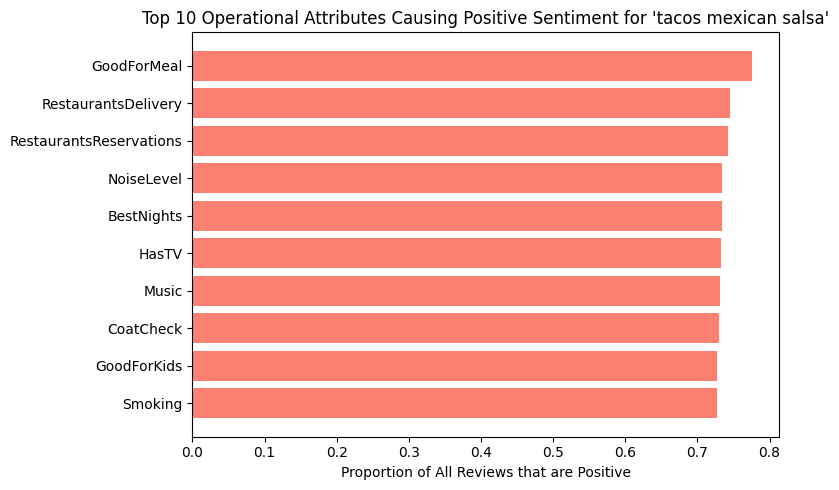

In [21]:
plot_top_negative_attributes(
    filtered_df,
    topic = "tacos mexican salsa"
)

plot_top_positive_attributes(
    filtered_df,
    topic = "tacos mexican salsa"
)

Operational Attribute Impact Analysis

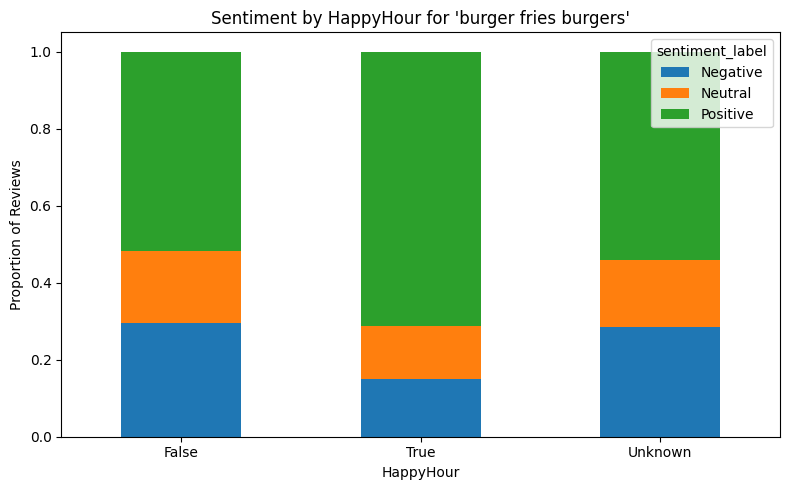

In [22]:
topic = "burger fries burgers"
attribute = "HappyHour"

topic_df = filtered_df[filtered_df["topic_label"] == topic]

sentiment_dist = (
    topic_df
    .groupby([attribute, "sentiment_label"])
    .size()
    .unstack(fill_value=0)
)

sentiment_dist = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0)

sentiment_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(8,5)
)

plt.title(f"Sentiment by {attribute} for '{topic}'")
plt.ylabel("Proportion of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Pareto Analysis of Negative Sentiment Drivers

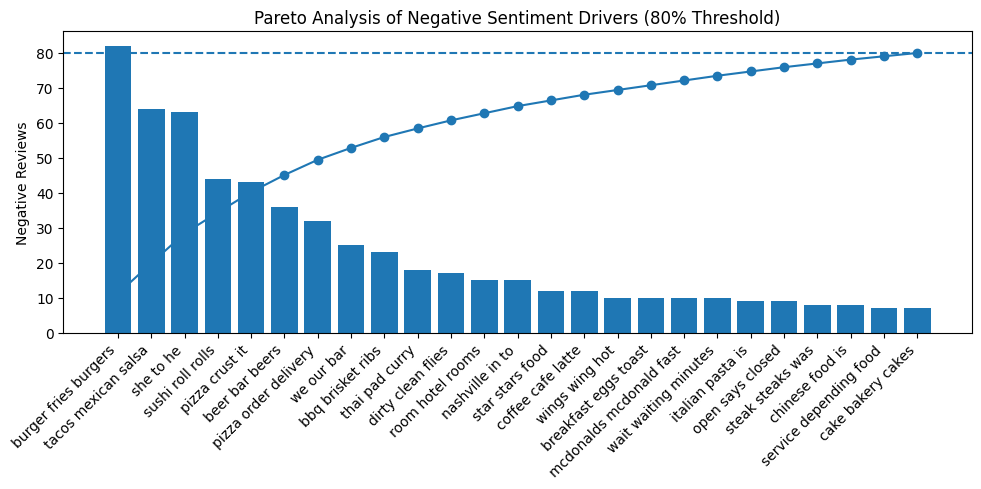

In [23]:
import matplotlib.pyplot as plt

#Count negative reviews per topic
neg_counts = (
    filtered_df[filtered_df["sentiment_label"] == "Negative"]
    ["topic_label"]
    .value_counts()
)

#Compute cumulative percentage
cum_pct = neg_counts.cumsum() / neg_counts.sum() * 100

#Keep only topics up to 80% cumulative impact
pareto_df = (
    cum_pct[cum_pct <= 80]
    .index
)

neg_counts_80 = neg_counts.loc[pareto_df]
cum_pct_80 = cum_pct.loc[pareto_df]

# Plot
plt.figure(figsize=(10,5))

plt.bar(neg_counts_80.index, neg_counts_80.values)
plt.plot(
    neg_counts_80.index,
    cum_pct_80.values,
    marker="o"
)

plt.axhline(80, linestyle="--")
plt.ylabel("Negative Reviews")
plt.title("Pareto Analysis of Negative Sentiment Drivers (80% Threshold)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Heatmap Analysis of Operational Drivers

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_single_topic_attribute_heatmap(filtered_df, topic):
    #Filter for topic
    topic_df = filtered_df[filtered_df["topic_label"] == topic]

    #Exclude non-operational columns
    exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
    attributes = [c for c in topic_df.columns if c not in exclude_cols]

    heatmap_data = []

    for attr in attributes:
        if topic_df[attr].dtype == "object":
            counts = (
                topic_df
                .groupby(attr)["sentiment_label"]
                .value_counts(normalize=True)
            )
            most_common_value = topic_df[attr].mode()[0]
            neg_score = counts.get((most_common_value, "Negative"), 0)

            heatmap_data.append({
                "attribute": attr,
                "negative_ratio": neg_score
            })

    heatmap_df = (
        pd.DataFrame(heatmap_data)
        .set_index("attribute")
        .sort_values("negative_ratio", ascending=False)
    )

    plt.figure(figsize=(4, max(6, len(heatmap_df) * 0.35)))
    sns.heatmap(
        heatmap_df,
        cmap="Reds",
        annot=True,
        fmt=".2f",
        cbar=True
    )

    plt.title(f"Negative Sentiment by Operational Attribute\nTopic: '{topic}'")
    plt.xlabel("")
    plt.ylabel("Operational Attributes")
    plt.tight_layout()
    plt.show()


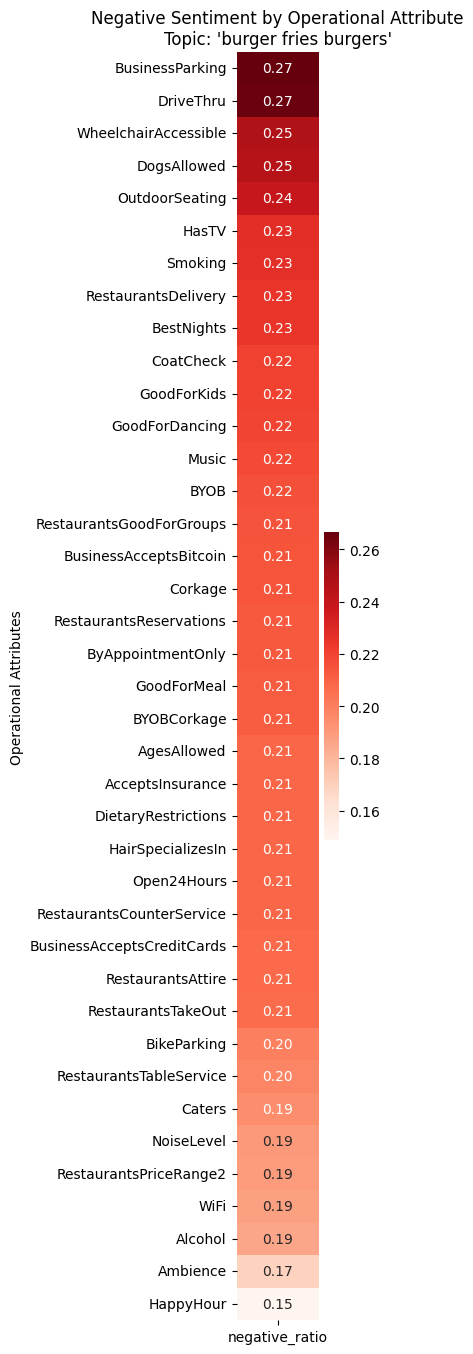

In [25]:
plot_single_topic_attribute_heatmap(
    filtered_df,
    topic="burger fries burgers"
)


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_single_topic_sentiment_heatmap(filtered_df, topic):
    #Filter for topic
    topic_df = filtered_df[filtered_df["topic_label"] == topic]

    #Exclude non-operational columns
    exclude_cols = ["business_id", "review", "topic", "topic_label", "sentiment", "sentiment_label"]
    attributes = [c for c in topic_df.columns if c not in exclude_cols]

    heatmap_data = []

    for attr in attributes:
        if topic_df[attr].dtype == "object":
            counts = (
                topic_df
                .groupby(attr)["sentiment_label"]
                .value_counts(normalize=True)
            )

            most_common_value = topic_df[attr].mode()[0]

            neg_ratio = counts.get((most_common_value, "Negative"), 0)
            pos_ratio = counts.get((most_common_value, "Positive"), 0)

            #Net sentiment score: positive - negative
            net_score = pos_ratio - neg_ratio

            heatmap_data.append({
                "attribute": attr,
                "net_sentiment": net_score
            })

    heatmap_df = (
        pd.DataFrame(heatmap_data)
        .set_index("attribute")
        .sort_values("net_sentiment", ascending=True)
    )

    plt.figure(figsize=(4, max(6, len(heatmap_df) * 0.35)))
    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn",
        center=0,
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Net Sentiment (Positive − Negative)"}
    )

    plt.title(f"Operational Attribute Sentiment Heatmap\nTopic: '{topic}'")
    plt.xlabel("")
    plt.ylabel("Operational Attributes")
    plt.tight_layout()
    plt.show()


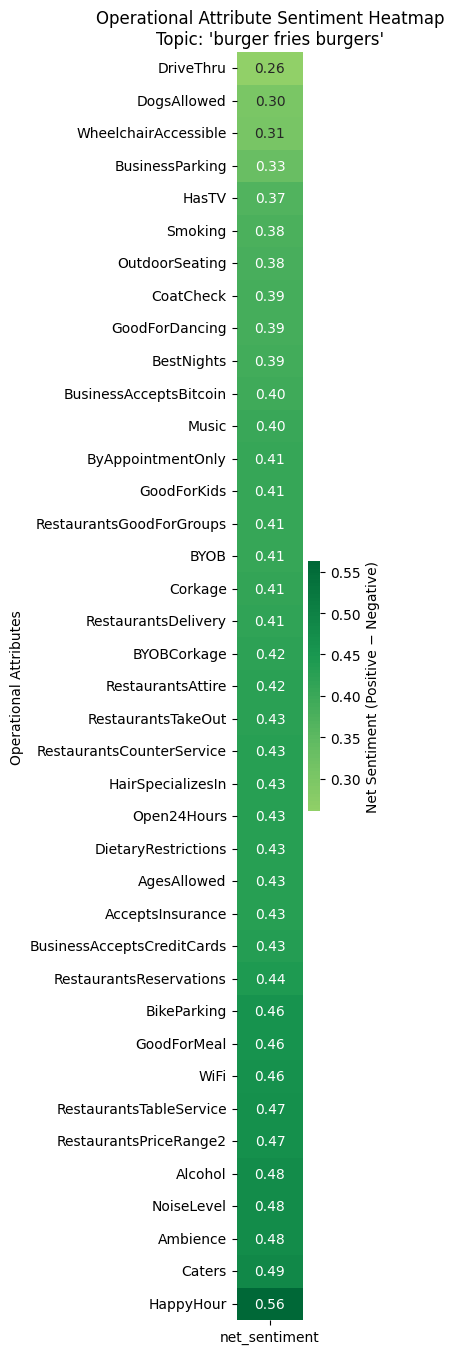

In [27]:
plot_single_topic_sentiment_heatmap(
    filtered_df,
    topic="burger fries burgers"
)


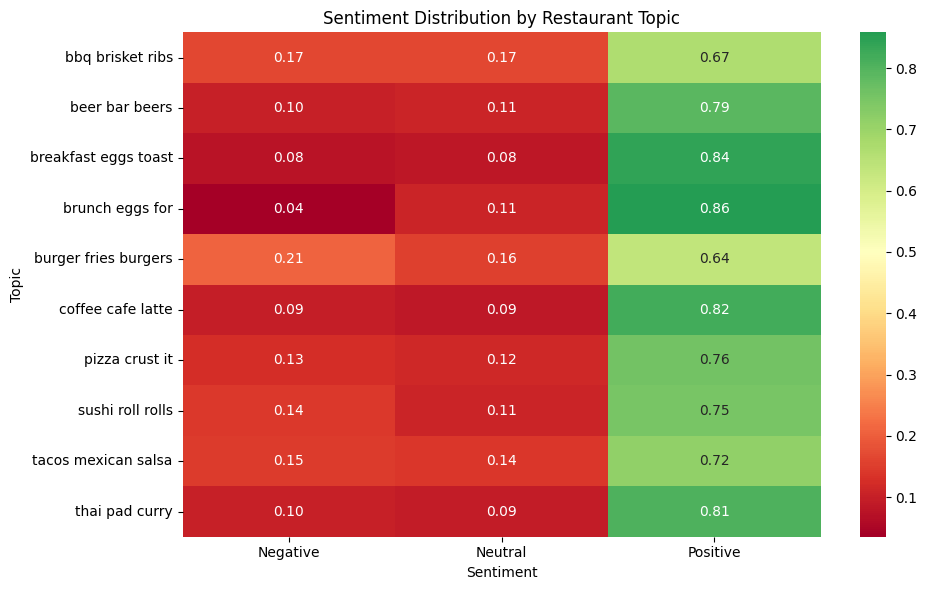

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 10 topics
top_topics = filtered_df['topic_label'].value_counts().head(10).index

# Filter dataframe to only include top topics
filtered_top_df = filtered_df[filtered_df['topic_label'].isin(top_topics)]

# Group by topic_label and sentiment
topic_sentiment = (
    filtered_top_df
    .groupby(["topic_label", "sentiment_label"])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions
topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    topic_sentiment_pct,
    cmap="RdYlGn",
    center=0.5,
    annot=True,
    fmt=".2f"
)
plt.title("Sentiment Distribution by Restaurant Topic")
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()
